## Prepare Environment

### Modules

In [1]:
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import torch
import scvi
import scanpy as sc
import sklearn

import matplotlib.pyplot as plt


/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(
    torch.backends.mps.is_available(),
    torch.cuda.is_available()
)

True False


### Utils

In [3]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

### Folder Structure

In [4]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

### Dataloading

In [5]:
adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
adata_sp, adata_sc

(AnnData object with n_obs × n_vars = 7416 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 2239 × 32287
     obs: 'cluster')

### Dataprep

In [6]:
# Choose one celltype from the available shared types to filter adata objects with
set.intersection(
    set(adata_sc.obs["cluster"]),
    set(adata_sp.obs["nico_ct"])
)

{'BZE',
 'Blood vasc.',
 'Cycling/GC B cell',
 'Glial',
 'Goblet',
 'Lymphatic',
 'MZE',
 'Macrophage',
 'Paneth',
 'Plasma',
 'Rest B',
 'Stem/TA',
 'Stroma',
 'T cell',
 'TZE',
 'Tuft',
 'cDC/monocyte',
 'neurons/enteroendocrine',
 'pDC'}

In [7]:
celltype = "Stem/TA"
adata_sc_filtered = adata_sc[adata_sc.obs["cluster"] == celltype].copy()
adata_sp_filtered = adata_sp[adata_sp.obs["nico_ct"] == celltype].copy()
adata_sc_filtered, adata_sp_filtered

(AnnData object with n_obs × n_vars = 420 × 32287
     obs: 'cluster',
 AnnData object with n_obs × n_vars = 997 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances')

## Benchmarking

In [8]:
model_nmf = sklearn.decomposition.NMF(
    n_components=3,
)

In [11]:
W = model_nmf.fit_transform(
   X=adata_sc_filtered.X.transpose() 
)
H = model_nmf.components_

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [12]:
sklearn.metrics.mean_squared_error(
    adata_sc_filtered.X.transpose().toarray(),
    W @ H
)

4.443471908569336

In [13]:
(W @ H).mean(axis=0).shape

(420,)

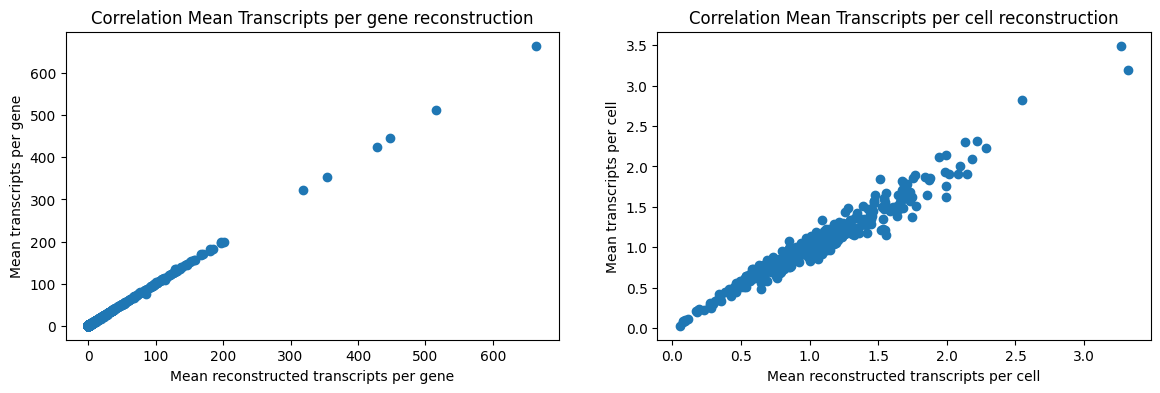

Correlation Coeff Gene Reconstruction: 0.9999169659970978 
Correlation Coeff Cell Reconstruction: 0.9769245072450792


In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=1),
    (W @ H).mean(axis=1),
)
axs[0].set_title("Correlation Mean Transcripts per gene reconstruction")
axs[0].set_xlabel("Mean reconstructed transcripts per gene")
axs[0].set_ylabel("Mean transcripts per gene")

axs[1].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=0),
    (W @ H).mean(axis=0),
)
axs[1].set_title("Correlation Mean Transcripts per cell reconstruction")
axs[1].set_xlabel("Mean reconstructed transcripts per cell")
axs[1].set_ylabel("Mean transcripts per cell")
plt.show()

print(
    f"Correlation Coeff Gene Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=1), (W @ H).mean(axis=1))[0, 1]}",
    f"\nCorrelation Coeff Cell Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=0), (W @ H).mean(axis=0))[0, 1]}",
)

In [15]:
np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=1), (W @ H).mean(axis=1))[0, 1]

np.float64(0.9999169659970978)

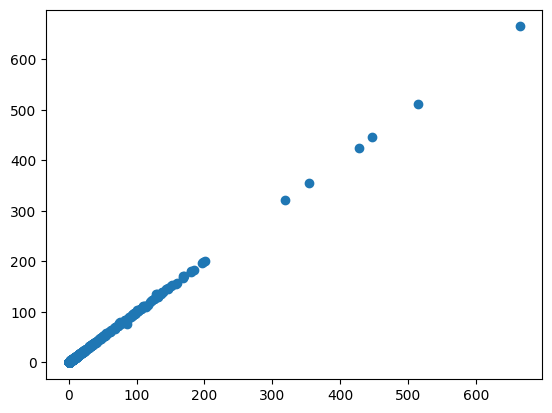

In [16]:
plt.scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=1),
    (W @ H).mean(axis=1)
)

In [17]:
W @ H

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.9510936e-02, 1.8198304e-02, 2.5800593e-02, ..., 0.0000000e+00,
        0.0000000e+00, 1.3450718e-04],
       ...,
       [7.1688294e+00, 7.3652601e+00, 7.0621791e+00, ..., 3.2995173e-01,
        2.5976071e-01, 1.1488306e-01],
       [5.8485281e-01, 7.6094228e-01, 5.8881468e-01, ..., 3.7522033e-02,
        3.1478971e-02, 1.1433557e-02],
       [9.1662025e-03, 1.2366830e-02, 6.9186175e-03, ..., 5.4275573e-05,
        2.2734080e-04, 0.0000000e+00]], dtype=float32)

In [18]:
adata_sc_filtered.X.transpose().toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 4., 4., ..., 0., 2., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
model_nmf.__dict__

{'n_components': 3,
 'init': None,
 'beta_loss': 'frobenius',
 'tol': 0.0001,
 'max_iter': 200,
 'random_state': None,
 'alpha_W': 0.0,
 'alpha_H': 'same',
 'l1_ratio': 0.0,
 'verbose': 0,
 'solver': 'cd',
 'shuffle': False,
 'n_features_in_': 420,
 '_n_components': 3,
 '_beta_loss': 2,
 'reconstruction_err_': np.float32(7758.449),
 'n_components_': 3,
 'components_': array([[21.26161   , 28.685678  , 16.04819   , ...,  0.12589577,
          0.52733195,  0.        ],
        [ 1.7029438 ,  0.        , 13.323036  , ...,  2.7921336 ,
          1.4286817 ,  0.93393123],
        [17.670965  , 10.897031  , 15.449235  , ...,  0.        ,
          0.        ,  0.08054207]], dtype=float32),
 'n_iter_': 200}

In [20]:
H = model_nmf.components_

In [21]:
W @ H

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.9510936e-02, 1.8198304e-02, 2.5800593e-02, ..., 0.0000000e+00,
        0.0000000e+00, 1.3450718e-04],
       ...,
       [7.1688294e+00, 7.3652601e+00, 7.0621791e+00, ..., 3.2995173e-01,
        2.5976071e-01, 1.1488306e-01],
       [5.8485281e-01, 7.6094228e-01, 5.8881468e-01, ..., 3.7522033e-02,
        3.1478971e-02, 1.1433557e-02],
       [9.1662025e-03, 1.2366830e-02, 6.9186175e-03, ..., 5.4275573e-05,
        2.2734080e-04, 0.0000000e+00]], dtype=float32)

In [22]:
res

NameError: name 'res' is not defined

In [ ]:
adata_sc_filtered.X.transpose()

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 2255357 stored elements and shape (32287, 420)>

In [ ]:
np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)

array([False, False, False, ..., False, False, False])

In [ ]:
set.intersection(
    set(adata_sp_filtered.var_names),
    set(adata_sc_filtered.var_names),
)

{'Acsl1',
 'Acta2',
 'Ada',
 'Adgrd1',
 'Adgrf5',
 'Adra1a',
 'Adra1b',
 'Adra2a',
 'Adra2b',
 'Adrb1',
 'Adrb2',
 'Adrb3',
 'Agr3',
 'Apob',
 'Avil',
 'C1qb',
 'C1qc',
 'Cadm1',
 'Ccl9',
 'Ccnl2',
 'Ccr3',
 'Ccr7',
 'Cd14',
 'Cd27',
 'Cd34',
 'Cd3d',
 'Cd3e',
 'Cd4',
 'Cd44',
 'Cd79a',
 'Cd79b',
 'Cd8a',
 'Cd8b1',
 'Chrm1',
 'Chrm2',
 'Chrm3',
 'Chrm4',
 'Clca3b',
 'Clec4a2',
 'Clec9a',
 'Cmc1',
 'Cnr1',
 'Cps1',
 'Crp',
 'Cspg4',
 'Cxcr5',
 'Cysltr1',
 'Cysltr2',
 'Drd1',
 'Drd3',
 'Drd4',
 'Elavl3',
 'Etv1',
 'Fcgr4',
 'Fcna',
 'Ffar1',
 'Ffar2',
 'Ffar3',
 'Ffar4',
 'Foxp3',
 'Fzd1',
 'Fzd10',
 'Fzd2',
 'Fzd3',
 'Fzd4',
 'Fzd5',
 'Fzd6',
 'Fzd7',
 'Fzd8',
 'Fzd9',
 'Galr1',
 'Galr2',
 'Galr3',
 'Gipr',
 'Glp1r',
 'Glp2r',
 'Gpbar1',
 'Gper1',
 'Gpr119',
 'Gpr174',
 'Gpr18',
 'Gpr31b',
 'Gpr34',
 'Gpr55',
 'Gpr84',
 'Gpr87',
 'Gzmb',
 'H2-Eb1',
 'Hhex',
 'Hmgb2',
 'Hrh1',
 'Hrh2',
 'Hrh3',
 'Htr1b',
 'Htr2a',
 'Htr2b',
 'Htr4',
 'Htr5b',
 'Htr7',
 'Icos',
 'Ifnar1',
 'Ifng',
 'Ighd'